In [366]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

np.set_printoptions(precision = 3)

POSITIVE = 1
NEGATIVE = -1

In [447]:
def plot_matrix(matrix_seq, xAx, labels):
    true_neg = list(mat[0][0] for mat in matrix_seq)
    false_neg = list(mat[1][0] for mat in matrix_seq)
    false_pos = list(mat[0][1] for mat in matrix_seq)
    true_pos = list(mat[1][1] for mat in matrix_seq)
    #xAx = list(range(len(matrix_seq)))
    plt.plot(xAx, true_neg, color = 'red', label = 'TN')
    plt.plot(xAx, false_neg, color = 'blue', label = 'FN')
    plt.plot(xAx, true_pos, color = 'green', label = 'TP')
    plt.plot(xAx, false_pos, color = 'black', label = 'FP')
    plt.legend(loc='best')
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.grid(linewidth=1)
    plt.show()
    return 


def plot_scores(scores, param, labels):
    plt.plot(param, scores)
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.grid(linewidth=1)
    plt.show()
    return

def plot_metrics(metrics, xAx, labels):
    marks = ['o','v','x','D']
    i = 0
    for key in metrics:
        plt.plot(xAx, metrics[key], label = key, marker = marks[i])
        i += 1
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.grid(linewidth = 1)
    plt.legend(loc='best')
    plt.show()
    return

def full_plot(mat, par, mat_lab):
        
#     plt.figure(figsize=(10,10))
#     plt.subplot(2,1,1)
#     plt.title("Confusion matrix")
#     plot_matrix(mat, par, mat_lab)
    
#     plt.figure(figsize = (10,10))
#     plt.subplot(2,1,1)
    
    plt.figure(figsize = (10,10))
    plt.subplot(2,1,1)
    plt.title("Positive metrics")
    metrics = get_metrics(mat, 'positive')
    best_scores = get_best_scores(metrics)
    best_scores['Parameter'] = par[best_scores['Parameter']]
    plot_metrics(metrics, par, mat_lab)
    
    print_scores(best_scores)
    
#     plt.figure(figsize = (10,10))
#     plt.subplot(2,1,2)
#     plt.title("Negative metrics")
#     metrics = get_metrics(mat, 'negative')
#     best_scores = get_best_scores(metrics)
#     best_scores['Parameter'] = par[best_scores['Parameter']]
#     plot_metrics(metrics, par, mat_lab)
    
#     print_scores(best_scores)
    return best_scores
    
def print_scores(scor):
    for key in scor:
        print(key, '\t\t-\t', "%.4f" % (scor[key]))
    return
    
def get_metrics(matrix_seq, cl):
    true_neg = np.asarray(list(mat[0][0] for mat in matrix_seq))
    false_neg = np.asarray(list(mat[1][0] for mat in matrix_seq))
    false_pos = np.asarray(list(mat[0][1] for mat in matrix_seq))
    true_pos = np.asarray(list(mat[1][1] for mat in matrix_seq))
    
    if cl == 'positive':
        accuracy = 100*(true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg)
        precision = 100*true_pos/np.add(true_pos, false_pos)
        recall = 100*true_pos/(true_pos + false_neg)
        FM = ((true_pos/(true_pos + false_pos))*(true_pos/(true_pos+false_neg)))**(1/2)
        F1score = 2*precision*recall/(precision+recall)
    elif cl == 'negative':
        accuracy = (true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg)
        precision = true_neg/np.add(true_neg, false_neg)
        recall = true_neg/(true_neg + false_pos)
        FM = ((true_pos/(true_pos + false_pos))*(true_pos/(true_pos+false_neg)))**(1/2)
        F1score = 2*precision*recall/(precision+recall)
        
    metr = dict()
    metr['Recall'] = recall
    metr['Precision'] = precision
    metr['F1 score'] = F1score
#     metr['Folwkes-Mallows'] = FM
    metr['Accuracy'] = accuracy
    return metr

def get_best_scores(metr):
    best_sc = dict()
    max_ind = np.argmax(metr['F1 score'])
    for key in metr:
        best_sc[key] = metr[key][max_ind]
    best_sc["Parameter"] = max_ind
    return best_sc


def show_pca(dataset, feat):
    X = dataset[feat]
    y = dataset['target']
    target_names = ['positive', 'negative']

    pca = PCA(n_components=len(feat))
    X_r = pca.fit(X).transform(X)

    colors = ['red', 'blue', 'darkorange']
    lw = 2

    for color, i, target_name in zip(colors, [NEGATIVE, POSITIVE], target_names):
        plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw, label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.show()
    
    return

def show_lda(dataset, feat):
    X = dataset[feat]
    y = dataset['target']
    target_names = ['positive', 'negative']

    lda = LinearDiscriminantAnalysis()
    X_r = lda.fit(X, y).transform(X)
    print (np.shape(X_r))
    colors = ['navy', 'turquoise']
    lw = 2

    plt.scatter(X_r[y == NEGATIVE,0], X_r[y == NEGATIVE,0], alpha=.8, color='red', label='negative')
    plt.show()
    plt.scatter(X_r[y == POSITIVE, 0], X_r[y == POSITIVE, 0], alpha=.8, color='blue', label='positive')
    
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.show()
    
    return

In [454]:
df = pd.read_csv('total_data_mining_dev.csv')

In [455]:
df = df.drop('contact_freq', 1)
df[df['target']==-1]

,Name,central_freq,central_freq_amp,peak_count,peak_mean,peak_SD,peak_matters_SD,peak_matters_Int,dixi,signal_peaks,sig_mean,sig_SD,p_mean,p_std,p_maxi,p_mini,target
0,semchuk6_0_Vid,1.279528,4.734345,10,0.809436,1.021315,3.842997,0.099316,3.829798e-16,20,-0.004179,0.060096,12.284211,7.418115,39.45,5.40,-1
1,semchuk6_10_Vid,1.279528,17.406748,9,2.418579,3.690358,4.061441,0.112123,1.238841e-15,21,-0.001300,0.064370,12.137500,7.348378,39.45,5.40,-1
2,semchuk6_20_Vid,1.279528,15.403416,9,2.100354,3.605699,3.689454,0.103189,4.641510e-16,22,0.001392,0.065290,11.488095,7.361045,39.45,5.05,-1
3,semchuk6_30_Vid,1.279528,12.015502,9,1.737424,2.958006,3.474664,0.089712,1.487421e-16,20,0.001603,0.065450,12.197368,7.507618,39.45,5.40,-1
4,semchuk6_40_Vid,0.885827,4.772490,8,0.841945,1.354857,2.901078,0.077288,9.330164e-16,20,0.003711,0.068406,12.007895,7.543056,39.45,5.40,-1
5,semchuk6_50_Vid,0.885827,12.999972,9,2.496979,3.625829,2.896715,0.074423,5.547620e-16,19,-0.001371,0.072751,12.336111,7.618742,39.45,5.40,-1
6,semchuk6_60_Vid,0.885827,7.384825,9,1.308452,2.124547,2.860079,0.072406,5.918974e-02,19,-0.002370,0.072382,12.419444,7.614244,39.45,5.40,-1
7,semchuk6_70_Vid,0.885827,6.098007,8,1.262910,1.754393,2.755994,0.071799,2.963605e-16,22,-0.002854,0.072416,11.723810,7.571070,39.45,5.10,-1
8,semchuk6_80_Vid,0.885827,18.144175,8,3.151104,5.189625,2.889047,0.078066,5.898113e-16,20,0.001048,0.075729,12.368421,7.675871,39.45,5.40,-1
9,semchuk6_90_Vid,0.885827,15.664931,8,2.627627,4.289473,3.039372,0.080210,2.272329e-16,19,0.001241,0.075159,12.197222,6.242851,30.95,5.40,-1


In [456]:
nulls = df[df['target']==NEGATIVE].count()
nulls = nulls['Name']
ones = df[df['target']==POSITIVE].count()
ones = ones['Name']

lenDiff = abs(nulls-ones)
halfLength = int(ones/2)
start = int(ones*2/3)
stop = int(ones/3)
print(halfLength)
print(lenDiff)

10
4372


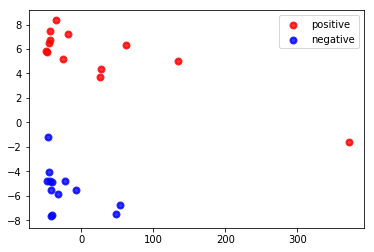

In [457]:
df_null = df[df['target']==NEGATIVE].iloc[lenDiff:]
df_ed = df[df['target']==POSITIVE]
df_train = pd.concat([df_null.head(start), df_ed.head(start)], ignore_index = True)
df_ver = pd.concat([df_null.tail(stop), df_ed.tail(stop)], ignore_index = True)

df_train.sample(frac=1).reset_index(drop=True)
df_ver.sample(frac=1).reset_index(drop=True)

# print(df_train[df_train['target']==NEGATIVE].count())
# print(df_train[df_train['target']==POSITIVE].count())
features = ['central_freq', 'central_freq_amp','peak_matters_SD', 'peak_matters_Int','sig_SD','sig_mean', 'dixi', 'signal_peaks']
features1 = ['peak_SD', 'peak_matters_SD', 'peak_matters_Int','sig_SD','sig_mean', 'dixi','sig_mean','sig_SD','p_maxi','p_mini', 'signal_peaks','p_mean', 'p_std']

show_pca(df_train, features1)

['peak_SD', 'peak_matters_SD', 'peak_matters_Int', 'sig_SD', 'sig_mean', 'dixi', 'sig_mean', 'sig_SD', 'p_maxi', 'p_mini', 'signal_peaks', 'p_mean', 'p_std']
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.

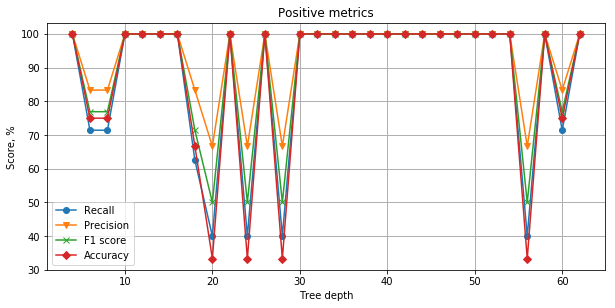

Recall 		-	 100.0000
Precision 		-	 100.0000
F1 score 		-	 100.0000
Accuracy 		-	 100.0000
Parameter 		-	 4.0000


In [458]:
# features = ['central_freq', 'central_freq_amp', 'peak_SD', 'peak_matters_SD', 'peak_matters_Int','sig_SD','sig_mean', 'dixi', 'signal_peaks','p_mean', 'p_std','p_maxi','p_mini']
features = features1
scores = []
conf_mat = []
deps = []
print(features)
for i in range(4,64, 2):    
    age_sal_tree = DecisionTreeClassifier(criterion='gini', max_depth=i, max_features = len(features), random_state=None)
    age_sal_tree.fit(df_train[features].values, df_train['target'].values)
    scoreRes = age_sal_tree.score(df_ver[features].values, df_ver['target'].values)
    res_pred = age_sal_tree.predict(df_ver[features].values)
    scores.append(scoreRes*100)
    conf_mat.append(100*confusion_matrix(res_pred, df_ver['target'].values)/halfLength)
    deps.append(i)
    print(age_sal_tree.feature_importances_)
    
full_plot(conf_mat, deps, ['Tree depth', 'Score, %'])

export_graphviz(age_sal_tree, out_file='tree.dot', precision=5)


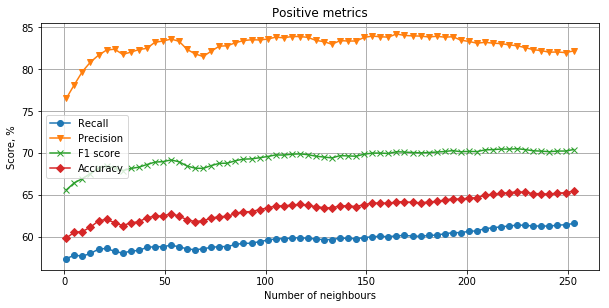

Recall 		-	 61.3848
Precision 		-	 82.8073
F1 score 		-	 70.5047
Accuracy 		-	 65.3580
Parameter 		-	 225.0000


{'Accuracy': 65.357967667436498,
 'F1 score': 70.504697400043696,
 'Parameter': 225,
 'Precision': 82.807287657172182,
 'Recall': 61.384820239680423}

In [408]:
neis = []
scores = []
conf_mat = []
for i in range(1,256, 4):
    nei = KNeighborsClassifier(n_neighbors=i)
    nei.fit(df_train[features].values, df_train['target'].values)
    scoreRes = nei.score(df_ver[features].values, df_ver['target'].values)
    neis.append(i)
    scores.append(scoreRes*100)
    res_pred = nei.predict(df_ver[features].values)
    conf_mat.append(100*confusion_matrix(res_pred, df_ver['target'].values)/halfLength)

full_plot(conf_mat, neis, ["Number of neighbours", "Score, %"])

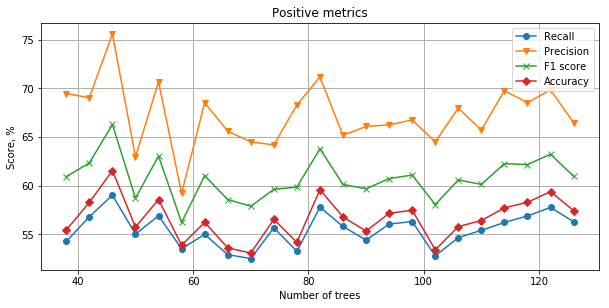

Recall 		-	 59.0180
Precision 		-	 75.5710
F1 score 		-	 66.2766
Accuracy 		-	 61.5473
Parameter 		-	 46.0000


{'Accuracy': 61.54734411085451,
 'F1 score': 66.276583774051986,
 'Parameter': 46,
 'Precision': 75.570952014370036,
 'Recall': 59.018036072144284}

In [409]:
# The official page of the algorithm states that random forest does not overfit,
# and you can use as much trees as you want. But Mark R. Segal 
# (April 14 2004. "Machine Learning Benchmarks and Random Forest Regression."
#  Center for Bioinformatics & Molecular Biostatistics) has found that it overfits
# for some noisy datasets. So to obtain optimal number you can try training random 
# forest at a grid of ntree parameter (simple, but more CPU-consuming) or build one 
# random forest with many trees with keep.inbag, calculate out-of-bag (OOB) error rates
# for first nn trees (where nn changes from 11 to ntree) and plot OOB error rate vs. 
# number of trees (more complex, but less CPU-consuming).

scores = []
estims = []
conf_mat = []

for i in range(38, 128, 4):    
    fore = RandomForestClassifier(n_estimators = i, max_features = len(features), random_state=None)
    fore.fit(df_train[features].values, df_train['target'].values)
    scoreRes = fore.score(df_ver[features].values, df_ver['target'].values)
    res_pred = fore.predict(df_ver[features].values)
#     print(age_sal_tree.feature_importances_)
    scores.append(scoreRes)
    conf_mat.append(confusion_matrix(res_pred, df_ver['target'].values)/halfLength)
    estims.append(i)
full_plot(conf_mat, estims, ["Number of trees", "Score, %"])


/home/ivan7chuk/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:421: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/home/ivan7chuk/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/ivan7chuk/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


newton-cg


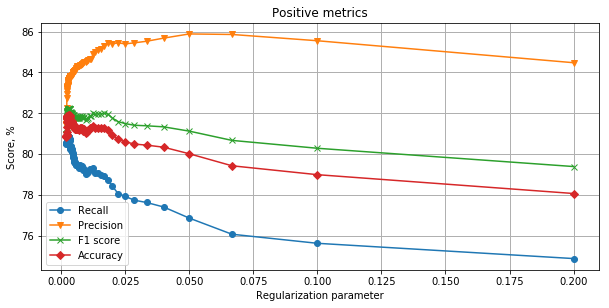

Recall 		-	 80.8073
Precision 		-	 83.7311
F1 score 		-	 82.2432
Accuracy 		-	 81.9220
Parameter 		-	 0.0031
lbfgs


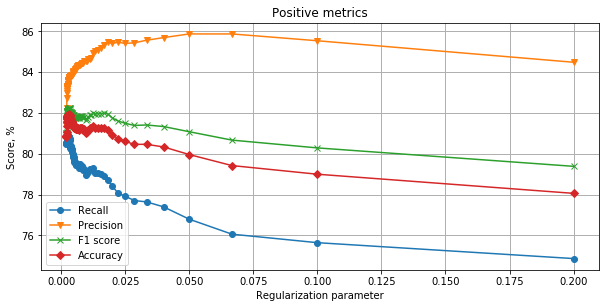

Recall 		-	 80.8273
Precision 		-	 83.7311
F1 score 		-	 82.2536
Accuracy 		-	 81.9348
Parameter 		-	 0.0031
liblinear


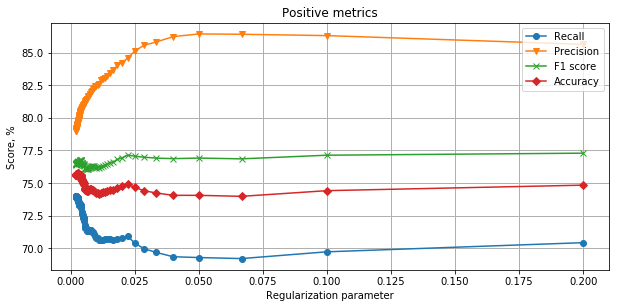

Recall 		-	 70.4219
Precision 		-	 85.6556
F1 score 		-	 77.2954
Accuracy 		-	 74.8396
Parameter 		-	 0.2000


/home/ivan7chuk/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


sag


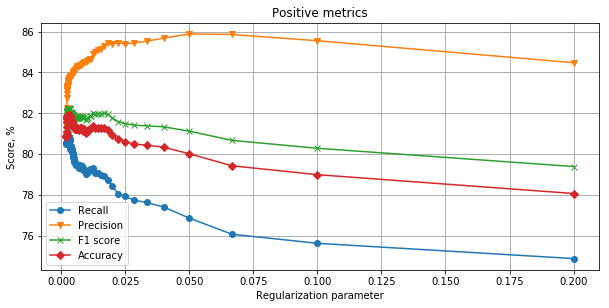

Recall 		-	 80.8073
Precision 		-	 83.7311
F1 score 		-	 82.2432
Accuracy 		-	 81.9220
Parameter 		-	 0.0031
saga


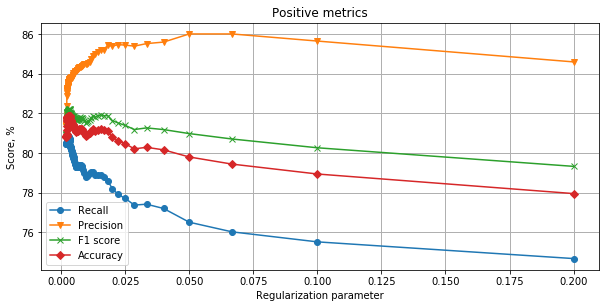

Recall 		-	 80.7369
Precision 		-	 83.7824
F1 score 		-	 82.2315
Accuracy 		-	 81.8963
Parameter 		-	 0.0033


In [403]:
lin_clf = linear_model.LogisticRegression()
penalties = ['l1','l2']

lin_clf.tol = 0.000001 
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for sol in solvers:
    lin_clf.solver = sol
    scores = []
    alphas = []
    conf_mat = []
    for i in range(10, 1000, 10):
        a = 2/i
        lin_clf.C = a
        lin_clf.fit(df_train[features].values, df_train['target'].values)
        scoreRes = lin_clf.score(df_ver[features].values, df_ver['target'].values)
        res_pred = lin_clf.predict(df_ver[features].values)
        scores.append(scoreRes)
        conf_mat.append(confusion_matrix(res_pred, df_ver['target'].values)/halfLength)
        alphas.append(a)
    print(sol)
    full_plot(conf_mat, alphas, ["Regularization parameter", 'Score, %'])
    plt.show()

saga


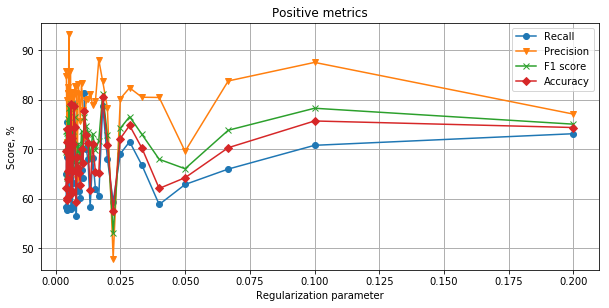

Recall 		-	 78.8113
Precision 		-	 83.7054
F1 score 		-	 81.1847
Accuracy 		-	 80.6005
Parameter 		-	 0.0182


In [404]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 5), activation = 'logistic', learning_rate = 'adaptive')
    

scores = []
alphas = []
conf_mat = []
for i in range(10, 500, 10):
    a = 2/i
    clf.alpha = a
    clf.fit(df_train[features].values, df_train['target'].values)
    scoreRes = clf.score(df_ver[features].values, df_ver['target'].values)
    res_pred = clf.predict(df_ver[features].values)
    scores.append(scoreRes)
    conf_mat.append(confusion_matrix(res_pred, df_ver['target'].values)/halfLength)
    alphas.append(a)
print(sol)
full_plot(conf_mat, alphas, ["Regularization parameter", 'Score, %'])
plt.show()

saga


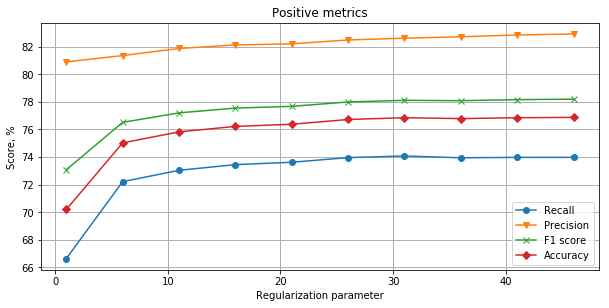

Recall 		-	 73.9698
Precision 		-	 82.9099
F1 score 		-	 78.1851
Accuracy 		-	 76.8668
Parameter 		-	 46.0000


In [407]:
clf = SVC(kernel = 'linear',degree = 2, C = 0.001)
    

scores = []
alphas = []
conf_mat = []
for i in range(1, 50, 5):
    a = i
    clf.C = a
    clf.fit(df_train[features].values, df_train['target'].values)
    scoreRes = clf.score(df_ver[features].values, df_ver['target'].values)
    res_pred = clf.predict(df_ver[features].values)
    scores.append(scoreRes)
    conf_mat.append(confusion_matrix(res_pred, df_ver['target'].values)/halfLength)
    alphas.append(a)
print(sol)
full_plot(conf_mat, alphas, ["Regularization parameter", 'Score, %'])
plt.show()